# Векторные репрезентации слов и документов
# Часть 4. Нейросетевые модели

## Оглавление
* Word2vec
* fastText
* GloVe (?)

## Введение

При обучении таких моделей (predictive models) целевым представлением каждого слова является сжатый вектор относительно небольшого размера (embedding), для которого максимизируется сходство с векторами соседей и минимизируется сходство с векторами слов, его соседями не являющихся. Подобные предсказательные модели представляют семантику естественного языка более точно, чем традиционные счётные модели, не использующие машинное обучение.

---
## Word2vec

**Word2Vec** -- это нейросетевой метод представления слов, который учитывает контекст, при этом уменьшая данные. Фактически, W2V есть два разных алгоритма: *continuous bag of words* (CBOW, непрерывный мешок слов) и *skip-gram*. Задачей метода CBOW является предсказание слова на основании близлежащих слов. У skip-gram обратная задача – предсказание набора близлежащих слов на основании одного слова. 

**Архитектура алгоритмов word2vec**  

<img src=https://cdn-images-1.medium.com/max/800/1*oi6grP1lnWWLCbRWaabiGA.png width="600">
<center>Tomas Mikolov. *Efficient Estimation of Word Representations in Vector Space*</center>

Первоначально каждое слово в словаре – случайный N-мерный вектор. Во время обучения алгоритм формирует оптимальный вектор для каждого слова так, чтобы векторы, соответствующие близким по смыслу словам, имели "сильную" косинусную близость, а далекие по смыслу слова -- "слабую". 

В качестве входных данных для алгоритма классификации можно использовать усредненный вектор, полученный из всех векторов слов документа. Однако в этом случае игнорируется порядок слов.  

**Резюме**
* Векторы вначале инициализируются случайными числами.
* Компоненты вектора -- обобщенные свойства семантического пространства
* Два обучающих алгоритма.
* Не поддерживает динамическое добавление новых слов. 
* Чтобы наблюдать сильные закономерности в векторном пространстве слов необходимо, чтобы модель быть обучена на большом наборе данных (до сотен миллиардов слов).
* Как оценить качество алгоритма? Качество модели зависит от размера обучающего набора данных, алгоритма, размера векторов.

**Проверить!** Чем чаще слово встречается в языке тем длиннее его вектор (упорядочить по частоте и посчитать L^2- норму)


## Загрузка данных
Задействование всех доступных виртуальных ядер [ссылка](https://software.intel.com/en-us/forums/intel-math-kernel-library/topic/294954)

In [1]:
%env MKL_DYNAMIC=FALSE
%env MKL_NUM_THREADS=8

env: MKL_DYNAMIC=FALSE
env: MKL_NUM_THREADS=8


Необходимые библиотеки

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

# Timing
import time

# For text analysis
import gensim
import fasttext
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
from gensim.models import word2vec
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

# For working with DataFrames and arrays
import csv
import random
import pickle
import numpy as np 
import pandas as pd
from collections import Counter
from scipy.stats import spearmanr

# Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Сериализация объектов и обратная загрузка

In [3]:
def pickling_data(name, data):
    out = open(name + '.pkl', 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

>**Замечание!**   
Доступ к корпусам (моделям) можно получить по ссылке[добавить]

In [4]:
path_data = '~/'
path_to_w2v = '/home/kulesh271828/arxiv/models/word2vec/'
file = path_data + 'corpora_lem.csv'

arxiv_id = pd.read_csv(path_data + 'corpora_lem.csv', chunksize=1, usecols=['arxiv_id'])
n_corpora = len([_id for _id in arxiv_id])
print("Corpora size: %d" % n_corpora)

Corpora size: 164197


"Ленивая" загрузка корпуса

In [5]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

class LazyCorpora:
    def __init__(self, file, n, collocation=False, reduce=1, merge=False):
        self.file = file
        self.n = n
        self.collocation = collocation
        self.reduce = reduce
        self.merge = merge
    
    def __iter__(self):
        chunks = pd.read_csv(self.file, iterator=True, encoding = "ISO-8859-1")
        
        for i in range(self.n):
            row = chunks.read(1)
            content = row['text'].values[0]
            condition = len(content.split()) < 15000 and i%self.reduce == 0
            if condition:
                if not self.collocation:
                    doc = content.split()
                else:
                    doc = self.collocation[content.split()]
                doc = [token for token in doc if token[0] in alphabet]
                if self.merge:
                    yield ' '.join(doc) 
                else:
                    yield doc

In [6]:
corpora = LazyCorpora(file, n_corpora, reduce=1)

In [7]:
for doc in corpora:
    print(doc[:100])
    break

['the', 'goal', 'of', 'this', 'paper', 'be', 'to', 'construct', 'invariant', 'dynamical', 'object', 'for', 'not', 'necessarily', 'invertible', 'smooth', 'self', 'map', 'of', 'compact', 'manifold', 'we', 'prove', 'result', 'that', 'take', 'advantage', 'of', 'difference', 'in', 'rat', 'of', 'expansion', 'in', 'the', 'term', 'of', 'sheaf', 'cohomological', 'long', 'exact', 'sequence', 'to', 'create', 'unique', 'lift', 'of', 'finite', 'dimensional', 'invariant', 'subspace', 'of', 'one', 'term', 'of', 'the', 'sequence', 'to', 'invariant', 'subspace', 'of', 'the', 'precede', 'term', 'this', 'allow', 'to', 'take', 'invariant', 'cohomological', 'class', 'and', 'under', 'the', 'right', 'circumstance', 'construct', 'unique', 'current', 'of', 'give', 'type', 'include', 'unique', 'measure', 'of', 'give', 'type', 'that', 'represent', 'those', 'class', 'and', 'be', 'invariant', 'under', 'pullback', 'dynamically', 'interest', 'self']


## Ключевые параметры
[ссылка]

**size** -- размер вектора (100-500)
- Чем меньше размер тем быстрее обучение; 
- Большой размер -- медленное обучение; 

**window** -- Размер окна (2-10)
- Узкое окно -- прямые взаимосвязи между словами
- Широкое окно -- тематические взаимосвязей между словами
- Предложение: на каждой эпохе обучения менять ширину окна (случайный выбор из фиксированного диапазона)


**negative** -- Количество негативных сэмплов (5-25) -- чем больше корпус тем меньше  
**iter** -- Количество эпох (по умолчанию 5)

#### Алгоритм обучения
- CBOW
- Skip-gram (медленнее обучается, но точнее) 

## Обучение моделей с параметрами по умолчанию

In [ ]:
print("Training CBOW model...")
%time model_cbow = word2vec.Word2Vec(corpora, sg=0, workers=8) 
model_cbow.wv.save_word2vec_format(path_to_w2v + 'w2v_cbow_100.bin', binary=True)

print("Training Skip-gram model...")
%time model_sg = word2vec.Word2Vec(corpora, sg=1, workers=8) 
model_sg.wv.save_word2vec_format(path_to_w2v + 'w2v_sg_100.bin',  binary=True)

>**Время обучение**
    1. CBOW: ~38min  
    2. Skip-gram: ~ 1h 23min

## Векторное пространство слов

In [74]:
# Загрузка модели
#
model = word2vec.KeyedVectors.load_word2vec_format(path_to_w2v + 'w2v_cbow_100.bin', binary=True)

In [76]:
model.most_similar('ball')

[('disk', 0.7809439897537231),
 ('disc', 0.7596030235290527),
 ('hypersphere', 0.7080216407775879),
 ('cube', 0.7059262990951538),
 ('sphere', 0.6997416019439697),
 ('circle', 0.6759076714515686),
 ('annulus', 0.6644521951675415),
 ('circumference', 0.6501538157463074),
 ('polydisc', 0.6473246216773987),
 ('radius', 0.6429730653762817)]

Вектор слова *ball*

In [78]:
print(model['ball'])

[  6.08102894e+00  -1.50791204e+00   3.58785123e-01  -1.24766362e+00
   1.45958960e+00   1.16289747e+00  -7.34277904e-01   1.28115430e-01
   4.68861866e+00   1.32781398e+00   5.04257500e-01  -3.02266312e+00
  -2.26002908e+00   2.10513568e+00  -2.57716680e+00   6.53858948e+00
   3.83354473e+00  -3.17009985e-01  -2.41870618e+00   2.12432981e-01
  -2.84367025e-01  -1.09343600e+00  -3.82450037e-02  -3.31872368e+00
  -2.22669864e+00   1.74384737e+00   6.61261305e-02  -6.13730609e-01
  -9.00447547e-01  -3.63534045e+00   2.00808740e+00  -1.03271377e+00
  -4.12039548e-01  -4.62734795e+00   3.27670050e+00  -1.36407089e+00
  -1.80336922e-01   2.17404556e+00  -5.66400230e-01   4.80360317e+00
   2.38684249e+00  -2.00334001e+00  -3.53684521e+00  -2.25017571e+00
  -6.64976314e-02   2.38587126e-01  -3.02377391e+00  -8.02234635e-02
   4.68977988e-01   3.24792933e+00   7.85880268e-01  -2.15629292e+00
  -3.74805808e+00   1.85132706e+00   1.51742971e+00  -3.06777358e+00
  -2.37931180e+00  -8.80029276e-02

In [83]:
def bow_with_freq(corpora):
    result = Counter()
    for s in corpora:
        result.update(s)
    return list(result.items())

Определяем частоту употребления каждого токена в корпусе

In [84]:
%%time

bow = bow_with_freq(corpora)
token_counts = pd.DataFrame(bow, columns=['token', 'count'])
sorted_tokens = token_counts.sort('count', ascending=False).set_index('token')

CPU times: user 19min 57s, sys: 3.75 s, total: 20min
Wall time: 20min 20s


In [85]:
#sorted_tokens.to_csv('sorted_tokens.csv')

In [86]:
sorted_tokens.head()

,count
token,
the,36048972
of,20015510
be,17016892
in,11029692
and,9808922


In [94]:
model.most_similar('the')

[('of', 0.68626868724823),
 ('this', 0.6104280948638916),
 ('where', 0.5966664552688599),
 ('these', 0.5781266689300537),
 ('and', 0.5715780258178711),
 ('which', 0.5534350872039795),
 ('our', 0.5526567101478577),
 ('in', 0.5462207794189453),
 ('it', 0.5201606154441833),
 ('by', 0.518502414226532)]

Проверим существует ли зависимость между частотой употребления термина и евклидовой нормой соответствующего вектора

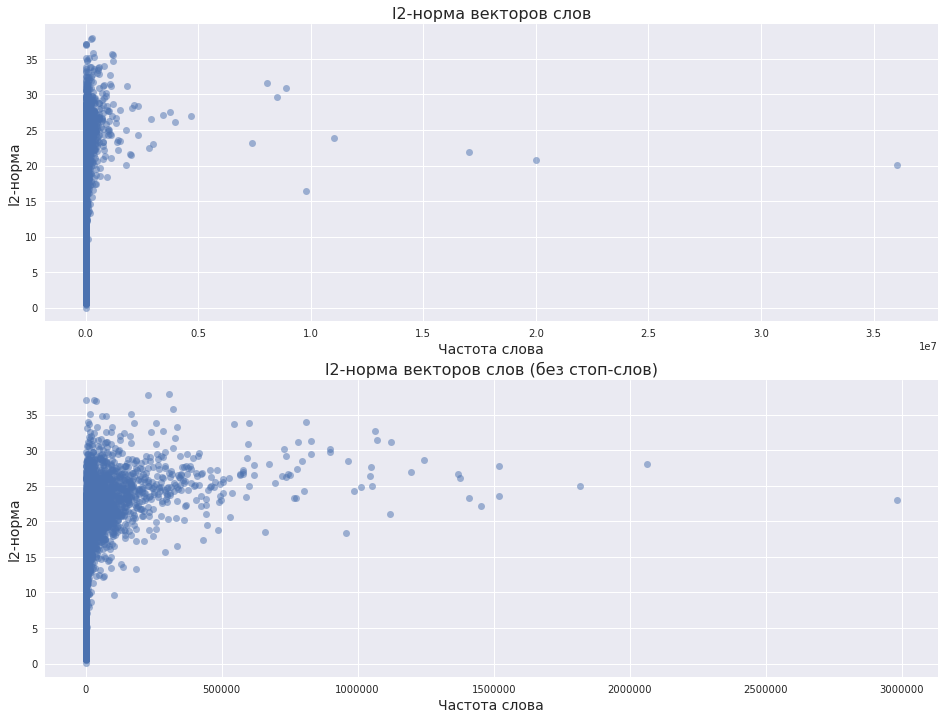

In [129]:
df = sorted_tokens[sorted_tokens['count'] > 20]
tokens = df.index
counts = df.count
norm = [np.linalg.norm(model[token]) for token in tokens]
df['norm'] = norm
data = df.sort_values(by='norm', ascending=False)

# Plotting
#
plt.figure(figsize=(16,12))

plt.subplot(2,1,1)
plt.plot(data['count'], data['norm'], 'o', alpha=0.5, ms=7.)
plt.title("l2-норма векторов слов", size=16)
plt.xlabel("Частота слова", size=14)
plt.ylabel("l2-норма", size=14)

plt.subplot(2,1,2)
ind = list(set(data.index) - stop)
data = data.loc[ind]
plt.plot(data['count'], data['norm'], 'o', alpha=0.5, ms=7.)
plt.title("l2-норма векторов слов (без стоп-слов)", size=16)
plt.xlabel("Частота слова", size=14)
plt.ylabel("l2-норма", size=14)

plt.show()

In [143]:
print("Коэффицент корреляции Спирмена: %.3f" % spearmanr(data['count'], data['norm']).correlation)

Коэффицент корреляции Спирмена: 0.016


Видим, что не наблюдается зависимости между частотой термина и величиной l2-нормы соответствующего вектора

## Изменение параметров моделей
**CBOW**

In [ ]:
%%time

model_cbow = word2vec.Word2Vec(corpora, min_count=20, window=10, size=200, workers=8)

In [23]:
dict(model_cbow.most_similar('triangle'))

{'hexagon': 0.6999695301055908,
 'hypotenuse': 0.6048201322555542,
 'octahedron': 0.5935043096542358,
 'parallelogram': 0.671776533126831,
 'pentagon': 0.6806566715240479,
 'polygon': 0.604572594165802,
 'quadrangle': 0.6268613338470459,
 'quadrilateral': 0.667422890663147,
 'rhombus': 0.6279386281967163,
 'tetrahedron': 0.6873685121536255}

In [20]:
# Saving

path_to_model = '/home/a_kulesh/arxiv/models/'
model_name = 'cbow_200.bin'
model_cbow.wv.save_word2vec_format(path_to_model + model_name, binary=True)

**Skip-gram**
1. [What is the output of a skip-gram model in Word2Vec?](https://www.quora.com/What-is-the-output-of-a-skip-gram-model-in-Word2Vec)  

[Описание]  

In [8]:
%%time

model_sg = word2vec.Word2Vec(corpora, sg=1, min_count=20, window=10, size=200, workers=8)

CPU times: user 1d 4h 53min 9s, sys: 19.9 s, total: 1d 4h 53min 29s
Wall time: 4h 46min 21s


In [80]:
dict(model_sg.most_similar('triangle'))

{'consequently': 0.5194365978240967,
 'cube': 0.5272855758666992,
 'equilateral': 0.5584828853607178,
 'face': 0.5919212102890015,
 'parallelogram': 0.5469095706939697,
 'quadrilateral': 0.527830958366394,
 'schwarz': 0.5221819281578064,
 'segment': 0.5460503697395325,
 'star': 0.521024227142334,
 'triangulation': 0.5414884686470032}

In [9]:
# Saving

path_to_model = '/home/a_kulesh/arxiv/models/'
model_name = 'sg_200.bin'
model_sg.wv.save_word2vec_format(path_to_model + model_name, binary=True)

## Обучение на коллокациях
[ссылка]

In [13]:
bigrams = Phrases(corpora)
trigram = Phrases(bigrams[corpora])

Транформируем корпус токенов в корпус коллокаций. Для первого документа выведем список коллокаций, которые он содержит.

In [46]:
corpora_collocation = LazyCorpora(file, n_corpora, collocation=trigram, reduce=1)

for doc in corpora_collocation:
    print([d for d in doc if '_' in d])
    break

['growth_rate', 'under_consideration', 'canonically_identify', 'derham_cohomology', 'dynamical_system', 'rather_than', 'most_importantly', 'other_word', 'growth_rate', 'pull_back', 'self_cohomomorphism', 'short_exact', 'commutative_diagram', 'self_cohomomorphism', 'give_rise', 'cohomologically_expansive', 'sufficiently_large', 'cohomologically_expansive', 'cohomologically_expansive', 'cohomologically_expansive', 'cohomologically_expansive', 'there_exist', 'there_exist', 'cohomologically_expansive', 'cohomologically_expansive', 'great_deal', 'cohomologically_expansive', 'commutative_diagram', 'there_exist', 'cohomologically_expansive', 'sufficiently_large', 'positive_integer', 'absolute_value', 'great_than', 'short_exact', 'there_exist', 'diagram_commute', 'cohomologically_expansive', 'there_exist', 'arbitrarily_large', 'banach_space', 'self_cohomomorphism', 'enough_injectives', 'absolute_value', 'banach_space', 'exponentially_decay', 'self_cohomomorphism', 'short_exact', 'self_cohomomo

/opt/lab/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


**CBOW**

In [48]:
%%time

model_cbow_col = word2vec.Word2Vec(corpora_collocation, sg=0, min_count=min_count, window=window, size=size, negative=negative, 
                                     workers=workers)

/opt/lab/anaconda/envs/py35/lib/python3.5/site-packages/gensim/models/phrases.py:274: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 6h 27min 20s, sys: 24.6 s, total: 6h 27min 45s
Wall time: 3h 14min 41s


In [81]:
dict(model_cbow_col.most_similar('triangle'))

{'equilateral_triangle': 0.7034749984741211,
 'hexagon': 0.7799846529960632,
 'octagon': 0.739836573600769,
 'parallelogram': 0.7350431084632874,
 'pentagon': 0.6857712864875793,
 'polygon': 0.7292060256004333,
 'quadrangle': 0.7560771703720093,
 'quadrilateral': 0.742328405380249,
 'rhombus': 0.7280043363571167,
 'tetrahedron': 0.7344236969947815}

In [49]:
# Saving

path_to_model = '/home/a_kulesh/arxiv/models/'
model_name = 'cbow_200_trigram.bin'
model_cbow_col.wv.save_word2vec_format(path_to_model + model_name, binary=True)

**Skip-gram**

In [56]:
%%time

model_sg_col = word2vec.Word2Vec(corpora_collocation, sg=1, min_count=min_count, window=window, size=size, negative=negative,
                                     workers=workers)

CPU times: user 1d 5h 52min 28s, sys: 32.4 s, total: 1d 5h 53min
Wall time: 4h 9min 57s


In [131]:
model_sg_col.most_similar('triangle')

[('face', 0.6798551082611084),
 ('polygon', 0.6724768877029419),
 ('parallelogram', 0.6340784430503845),
 ('hexagon', 0.6292155981063843),
 ('triangulation', 0.613510251045227),
 ('cube', 0.6063944101333618),
 ('corner', 0.6031452417373657),
 ('segment', 0.601087212562561),
 ('rectangle', 0.600116491317749),
 ('quadrilateral', 0.5888450145721436)]

In [163]:
# Saving

model_name = 'sg_200_trigram.bin'
model_sg_col.wv.save_word2vec_format(path_to_model + model_name, binary=True)

## Корректировка параметров
- Варьирование контекстного окна  (отмена)
- Увеличение размера слоя  
- Увеличение количества эпох обучения (отмена)

In [69]:
trigram = Phrases.load('collocation.model')
trigram[['open','ball']]

['open_ball']

In [73]:
#corpora_collocation = LazyCorpora(file, n_corpora, collocation=trigram, reduce=1)

**CBOW**

In [76]:
%%time

model_cbow = word2vec.Word2Vec(corpora, sg=0, min_count=20, window=10, size=500, negative=5, workers=8)

CPU times: user 21h 51min, sys: 54.9 s, total: 21h 51min 54s
Wall time: 3h 5min 26s


In [77]:
# Saving

model_name = 'cbow_500.bin'
model_cbow.wv.save_word2vec_format(path_to_w2v + model_name, binary=True)

In [92]:
model_cbow.most_similar('triangle')

[('hexagon', 0.5854527354240417),
 ('tetrahedron', 0.5817880630493164),
 ('parallelogram', 0.5681203603744507),
 ('quadrilateral', 0.550495982170105),
 ('rhombus', 0.544863224029541),
 ('octagon', 0.5153114795684814),
 ('pentagon', 0.5127409100532532),
 ('isosceles', 0.5049142837524414),
 ('rectangle', 0.4979400932788849),
 ('polygon', 0.4933820962905884)]

**Skip-gram**

In [78]:
%%time

model_sg = word2vec.Word2Vec(corpora, sg=1, min_count=20, window=10, size=500, negative=5, workers=8)

CPU times: user 4d 3h 41min 22s, sys: 51.9 s, total: 4d 3h 42min 14s
Wall time: 12h 39min 10s


In [79]:
# Saving

model_name = 'sg_500.bin'
model_sg.wv.save_word2vec_format(path_to_w2v + model_name, binary=True)

In [98]:
model_sg.most_similar('triangle')

[('equilateral', 0.46741896867752075),
 ('segment', 0.45845645666122437),
 ('face', 0.4561383128166199),
 ('isosceles', 0.4550643563270569),
 ('tetrahedron', 0.451308012008667),
 ('triangulation', 0.444807231426239),
 ('polygon', 0.4289226830005646),
 ('triangular', 0.42612844705581665),
 ('quadrilateral', 0.4230349659919739),
 ('angle', 0.4180520176887512)]

## fastText
[Описание]  
![fasttext](https://psv4.userapi.com/c816228/u106286082/docs/c5b725fdd406/fasttext.png?extra=lkAHEgzPA6OuKS7JJgtFHyQzkH6Xzqi-8fuUoghUVLpi_aYkGM9FYQMLzAtG6-Ys5Ah3zK7PkPycnpyIKj9T6P15b8Np8PMB5sGbhbmu8lvsgk3OnFBFFoEKX7E)

Преобразование корпуса в необходимый для fasttext формат

In [9]:
ft_home = '/home/kulesh271828/fastText/fasttext'

file = open('corpora.txt', 'w')
for doc in corpora:
    line = ' '.join(doc)
    file.write(line)
file.close()

In [10]:
file = open('corpora.txt', 'r')
for line in file:
    print(line[:1000])
    break

the goal of this paper be to construct invariant dynamical object for not necessarily invertible smooth self map of compact manifold we prove result that take advantage of difference in rat of expansion in the term of sheaf cohomological long exact sequence to create unique lift of finite dimensional invariant subspace of one term of the sequence to invariant subspace of the precede term this allow to take invariant cohomological class and under the right circumstance construct unique current of give type include unique measure of give type that represent those class and be invariant under pullback dynamically interest self map may have plethora of invariant measure so the uniquess of the construct current be important it mean that if local growth be not too big compare to the growth rate of the cohomological class then the expand cohomological class give sufficient march order of any other such invariant current of the same type say from some local dynamical subsystem because we use s

### Обучание моделей с параметрами по умолчанию

In [3]:
# путь к обученным моделям
#
path_to_models = '/home/kulesh271828/arxiv/models/fasttext/'

In [4]:
print("Training CBOW model...")
%time model = fasttext.cbow('corpora.txt', path_to_models + 'ft_cbow_100.model', silent=0)

print("Training Skip-gram model...")
%time model = fasttext.skipgram('corpora.txt', path_to_models + 'ft_sg_100.model', silent=0)

Training CBOW model...
CPU times: user 9h 5min 14s, sys: 40.9 s, total: 9h 5min 55s
Wall time: 1h 9min 12s
Training Skip-gram model...
CPU times: user 11h 21min 45s, sys: 41.9 s, total: 11h 22min 26s
Wall time: 1h 26min 20s


### Изменение параметров

**input_file**     -- путь к корпусу (текстовый документ с кодировкой utf-8)    

**output**         -- имя модели и папка сохранения  

**lr**            -- параметр обучения [0.05]  

**dim**            -- размерность векторов слов [100]  
Увеличим размер вектора до 300  

**ws**             -- ширина контекстного окна [5]  
Увеличим размер окна. Здесь так же, как и в модели w2v, узкое окно улавливает прямые взаимосвязи, а широкое -- тематические 

**epoch**          -- количество эпох обучения [5]  
Чтобы повысить качество обучения, увеличим кол-во эпох вдвое  

**min_count**      -- минимальное число всречаемости слова в корпусе [5]  
Чтобы сократить размер словаря, увеличим порог до 20 слов

**neg**            -- число негативных сэмплов [5]  
**word_ngrams**    -- максимальная длина n-грамм слов [1]  
Выбрибаем 3-граммы  

**loss**           -- функция потерь {ns, hs, softmax} [ns]  

**minn**           -- минимальная длина n-грамм символов [3]  

**maxn**           -- максимальная длина n-грамм символов [6]  

**thread**         -- число ядер [12]  

**silent**         -- отключить вывод журнала [1]  

In [6]:
print("Training CBOW model...")
%time model = fasttext.cbow('corpora.txt', path_to_models + 'ft_cbow_300.model', silent=0, dim = 300, \
                            ws = 8, epoch = 10, min_count = 20, word_ngrams = 3)

print("Training Skip-gram model...")
%time model = fasttext.skipgram('corpora.txt', path_to_models + 'ft_sg_300.model', silent=0, dim = 300, \
                            ws = 8, epoch = 10, min_count = 20, word_ngrams = 3)

Training CBOW model...
CPU times: user 2d 19h 36min 57s, sys: 2min 20s, total: 2d 19h 39min 17s
Wall time: 8h 28min 58s
Training Skip-gram model...
CPU times: user 3d 11h 48min 49s, sys: 3min 16s, total: 3d 11h 52min 6s
Wall time: 10h 30min 47s


# От вектора слова к вектору документа

## Word2vec. Средний вектор
[Описание]

In [8]:
#from sklearn.preprocessing import normalize

# путь к обученным моделям
#
path_to_w2v = '/home/kulesh271828/arxiv/models/word2vec/'
#n_corpora = sum([1 for doc in corpora])
n_corpora = 163100

In [9]:
print("Размер корпуса: %d" % n_corpora)

Размер корпуса: 163100


In [69]:
def docVector(words, model, voc, n_features, doc_num, tfidf=False, tf_table=None, idf=False, idf_table=None):
    
    vector = np.zeros((n_features,), dtype='float32')
    nwords = 0.
    weigth = 1
    
    for word in words:
        if word in voc and word not in stop: 
            nwords = nwords + 1.
            try: 
                if tfidf:
                    weigth = tf_table[word] * get_idf(idf_table, word, n_corpora)
                elif idf:
                    weigth = get_idf(idf_table, word, n_corpora)
                vector = np.add(vector, weigth * np.array(model[word]))
            except KeyError:
                continue
    vector = np.divide(vector, nwords)
    return vector


def docsTransformation(documents, model, voc, n_corpora, n_features, tfidf=False, tf_table=None, idf=False):
    counter = 0
    featureMatrix = np.zeros((n_corpora, n_features), dtype='float32')
    
    print("Making matrix of documents representation...")
    for doc in documents:
        if idf or tfidf:
            idf_table = Counter(doc)
        featureMatrix[counter] = docVector(doc, model, voc, n_features, counter, tfidf, tf_table, idf, idf_table)
        counter = counter + 1
        if counter%20000 == 0:
            print(counter)
    return featureMatrix

In [22]:
models = [file for file in os.listdir(path_to_w2v) if 'average' not in file]
models

['w2v_cbow_100.bin',
 'w2v_sg_200_trigram.bin',
 'w2v_sg_100.bin',
 'w2v_cbow_200_trigram.bin',
 'w2v_cbow_200.bin',
 'w2v_sg_200.bin',
 'w2v_cbow_300_trigram.bin',
 'w2v_sg_300_trigram.bin']

In [30]:
model = word2vec.KeyedVectors.load_word2vec_format(path_to_w2v + 'w2v_cbow_300_trigram.bin', binary=True)
model.most_similar('ball')

[('radius', 0.6426334381103516),
 ('disk', 0.6296803951263428),
 ('ham_ball', 0.6273855566978455),
 ('disc', 0.6203694343566895),
 ('unit_ball', 0.6092531681060791),
 ('sphere', 0.5739451050758362),
 ('concentric_ball', 0.542303204536438),
 ('spherical_cap', 0.5168668031692505),
 ('cub', 0.5052310824394226),
 ('inscribe_ball', 0.5002018213272095)]

**Униграммы**

In [71]:
print("Unigram models transformation")
for name in models:
    if 'trigram' not in name:
        model = word2vec.KeyedVectors.load_word2vec_format(path_to_w2v + name, binary=True)
        voc = model.vocab
        n_features = len(model.word_vec('set'))
        print(name)
        %time X = docsTransformation(corpora, model, voc, n_corpora, n_features)
        pickling_data(path_to_w2v + 'average_' + name, X)

Unigram models transformation
w2v_cbow_100.bin
Making matrix of documents representation...
CPU times: user 53min 55s, sys: 2.52 s, total: 53min 57s
Wall time: 1h 9s
w2v_sg_100.bin
Making matrix of documents representation...
CPU times: user 47min 14s, sys: 2.4 s, total: 47min 17s
Wall time: 51min 51s
w2v_cbow_200.bin
Making matrix of documents representation...
CPU times: user 1h 2min 36s, sys: 2.82 s, total: 1h 2min 39s
Wall time: 1h 10min 12s
w2v_sg_200.bin
Making matrix of documents representation...
CPU times: user 1h 1min 33s, sys: 2.9 s, total: 1h 1min 36s
Wall time: 1h 11min 42s


In [85]:
added = ['cbow_500.bin','sg_500.bin']

corpora_collocation = LazyCorpora(file, n_corpora)

print("Collocation models transformation")
for name in added:
    model = word2vec.KeyedVectors.load_word2vec_format(path_to_w2v + name, binary=True)
    voc = model.vocab
    n_features = len(model.word_vec('set'))
    print(name)
    %time X = docsTransformation(collocation, model, voc, n_corpora, n_features)
    pickling_data(path_to_w2v + 'average_' + name, X)
    print('\n')

Collocation models transformation
cbow_500_trigram.bin
Making matrix of documents representation...
CPU times: user 41min 32s, sys: 4.76 s, total: 41min 37s
Wall time: 41min 36s


sg_500_trigram.bin
Making matrix of documents representation...
CPU times: user 41min 8s, sys: 5.56 s, total: 41min 14s
Wall time: 41min 13s




**Коллокации**

In [84]:
collocation_model = Phrases.load('collocation.model')
collocation_model[['open','ball']]

['open_ball']

In [73]:
corpora_collocation = LazyCorpora(file, 164197, collocation=collocation_model)

print("Collocation models transformation")
for name in models:
    if 'trigram' in name:
        model = word2vec.KeyedVectors.load_word2vec_format(path_to_w2v + name, binary=True)
        voc = model.vocab
        n_features = len(model.word_vec('set'))
        print(name)
        %time X = docsTransformation(corpora_collocation, model, voc, n_corpora, n_features)
        pickling_data(path_to_w2v + 'average_' + name, X)

Collocation models transformation
w2v_sg_200_trigram.bin
Making matrix of documents representation...
CPU times: user 2h 14min 44s, sys: 6.46 s, total: 2h 14min 51s
Wall time: 2h 30min 52s
w2v_cbow_200_trigram.bin
Making matrix of documents representation...
CPU times: user 2h 16min 25s, sys: 7.56 s, total: 2h 16min 33s
Wall time: 2h 18min 12s
w2v_cbow_300_trigram.bin
Making matrix of documents representation...
CPU times: user 2h 17min 25s, sys: 7.41 s, total: 2h 17min 32s
Wall time: 2h 18min 40s
w2v_sg_300_trigram.bin
Making matrix of documents representation...
CPU times: user 2h 2min, sys: 7.19 s, total: 2h 2min 8s
Wall time: 2h 3min 36s


## Word2vec. Взвешенный средний вектор
$$tf-idf(t,d) = tf(t,d) * idf(t)$$
$$idf(t) = log\frac{n_d}{1 + df(d,t)}$$

### IDF
По материалам статьи [Words are not Equal: Graded Weighting Model for building Сomposite Document Vectors](https://arxiv.org/pdf/1512.03549v1.pdf) 

In [12]:
def get_idf(table, word, n_corpora):
    df_word = table[word]
    return np.log(n_corpora / df_word)

In [53]:
names = ['w2v_cbow_500.bin','w2v_sg_500.bin']

for name in names:
    model = word2vec.KeyedVectors.load_word2vec_format(path_to_w2v + name, binary=True)
    voc = model.vocab
    n_features = len(model.word_vec('set'))
    %time X = docsTransformation(corpora, model, voc, n_corpora, n_features, tfidf=False, idf=True)
    pickling_data(path_to_w2v + 'average-idf_' + name[:-4], X)

Making matrix of documents representation...
20000
40000
60000
80000
100000
120000
140000
160000
CPU times: user 1h 33min 19s, sys: 12.7 s, total: 1h 33min 32s
Wall time: 1h 43min 3s
Making matrix of documents representation...
20000
40000
60000
80000
100000
120000
140000
160000
CPU times: user 1h 12min 33s, sys: 2.94 s, total: 1h 12min 36s
Wall time: 1h 15min 39s


### TF-IDF

In [14]:
tf = pd.read_csv('sorted_tokens.csv', index_col='token')
tf.columns = ['tf']
tf.head()

,tf
token,
the,36048972
of,20015510
be,17016892
in,11029692
and,9808922


In [42]:
tf_table = tf.to_dict()['tf']
%timeit tf_table['set'] 

The slowest run took 51.48 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 92.1 ns per loop


In [54]:
names = ['w2v_cbow_500.bin','w2v_sg_500.bin']

for name in names:
    model = word2vec.KeyedVectors.load_word2vec_format(path_to_w2v + name, binary=True)
    voc = model.vocab
    n_features = len(model.word_vec('set'))
    %time X = docsTransformation(corpora, model, voc, n_corpora, n_features, tfidf=True, tf_table=tf_table)
    pickling_data(path_to_w2v + 'average-tfidf_' + name[:-4], X)
    print('\n')

Making matrix of documents representation...
20000
40000
60000
80000
100000
120000
140000
160000
CPU times: user 1h 5min 59s, sys: 10.3 s, total: 1h 6min 10s
Wall time: 1h 12min 36s


Making matrix of documents representation...
20000
40000
60000
80000
100000
120000
140000
160000
CPU times: user 54min 35s, sys: 4.06 s, total: 54min 39s
Wall time: 58min 23s




## FastText

In [64]:
path_to_ft = '/home/kulesh271828/arxiv/models/fasttext/'
os.listdir(path_to_ft)

['ft_cbow_300.model.bin',
 'ft_cbow_100.model.bin',
 '.ipynb_checkpoints',
 'ft_sg_300.model.bin',
 'ft_cbow_300.model.vec',
 'ft_sg_100.model.vec',
 'ft_cbow_100.model.vec',
 'ft_sg_100.model.bin',
 'ft_sg_300.model.vec']

### Vectors from model

In [ ]:
file = file =  '~/corpora_lem.csv'
n = 164197
texts = LazyCorpora(file, n, merge=True)

for text in texts:
    t = text
    print(t[:1000])
    break

In [ ]:
def ft_docsTransformation(texts, model, n_corpora=163100):
    counter = 0
    n_features = model.dim
    featureMatrix = np.zeros((n_corpora, n_features), dtype='float32')
    
    print("Making matrix of documents representation...")
    for text in texts:
        featureMatrix[counter] = np.array(model[text])
        counter = counter + 1
        if counter%30000 == 0:
            print(counter)
    return featureMatrix

>ft_cbow_100.model  
**CPU times**: user 44min 42s, sys: 7.56 s, total: 44min 49s  
**Wall time**: 57min 35s

>ft_cbow_300.model  
**CPU times**: user 2h 16min 14s, sys: 9.86 s, total: 2h 16min 24s  
**Wall time**: 3h 23min 58s  

>ft_sg_100.model  
**CPU times**: user 1h 28min 34s, sys: 10.7 s, total: 1h 28min 45s  
**Wall time**: 1h 50min 27s  

>ft_sg_100.model  
**CPU times**: user 1h 28min 54s, sys: 4.37 s, total: 1h 28min 58s  
**Wall time**: 1h 33min 24s

### IDF

In [ ]:
names = ['ft_cbow_300.model.bin','ft_sg_300.model.bin']

for name in names:
    model = fasttext.load_model(path_to_ft + name)
    voc = model.words
    n_features = model.dim
    %time X = docsTransformation(corpora, model, voc, n_corpora, n_features, tfidf=False, idf=True)
    pickling_data(path_to_ft + 'average_ft-idf_' + name[:-4], X)

>ft_cbow_300.model  
**CPU times**: user 3h 5min 15s, sys: 9.78 s, total: 3h 5min 25s  
**Wall time**: 4h 7min 45s  

>ft_sg_300.model  
**CPU times**: user 3h 39min 26s, sys: 6.82 s, total: 3h 39min 33s  
**Wall time**: 4h 25min 51s

In [71]:
model = fasttext.load_model(path_to_ft + 'ft_sg_300.model.bin')
voc = model.words
n_features = model.dim
%time X = docsTransformation(corpora, model, voc, n_corpora, n_features, tfidf=False, idf=True)
pickling_data(path_to_ft + 'average_ft-idf_' + 'ft_sg_300.model', X)

Making matrix of documents representation...
20000
40000
60000
80000
100000
120000
140000
160000
CPU times: user 3h 37min 52s, sys: 7.64 s, total: 3h 37min 59s
Wall time: 5h 58min 26s


## Источники
1. models.phrases – Phrase (collocation) detection [link](http://radimrehurek.com/gensim/models/phrases.html)  
2. Radim Řehůřek. [Word2vec Tutorial](https://rare-technologies.com/word2vec-tutorial/)  
- [word2vec (2): CBOW, skip-gram](https://algorithmsdatascience.quora.com/word2vec-2-CBOW-skip-gram-1)  
- @torselllo. [Немного про word2vec: полезная теория](http://nlpx.net/archives/179)
- C.Батрунов. [Построение векторных представлений для многозначных слов](http://www.machinelearning.ru/wiki/images/9/9d/BartunovLSM.pdf)  
- T. Mikolov, [Efficient Estimation of Word Representations in Vector Space](http://arxiv.org/abs/1301.3781)
- Matt J. Kusner, Yu Sun, Nicholas I. [From Word Embeddings To Document Distances](http://jmlr.org/proceedings/papers/v37/kusnerb15.pdf)  
- Y. Bengio, [A Neural Probabilistic Language Model](http://jmlr.org/papers/volume3/tmp/bengio03a.pdf)  
- M. Taddy. [Document Classification by Inversion of Distributed Language Representations](http://arxiv.org/pdf/1504.07295v3.pdf)
- Пономарев С. [Word2Vec: классификация текстовых документов](https://habrahabr.ru/post/277563/) -- Habrahabr, 2016.
- JAYANT JAIN. [FastText and Gensim word embedding](https://rare-technologies.com/fasttext-and-gensim-word-embeddings/)  
- @tmylk. [Using FastText via Gensim](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/FastText_Tutorial.ipynb)  
- @tmylk. [Comparison of FastText and Word2Vec](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Word2Vec_FastText_Comparison.ipynb)  
- A [Python interface](https://pypi.python.org/pypi/fasttext) for Facebook fastText library
- Armand Joulin, Edouard Grave, Piotr Bojanowski, Tomas Mikolov. [Bag of Tricks for Efficient Text Classification](https://arxiv.org/pdf/1607.01759.pdf)  
- P. Bojanowski*, E. Grave*, A. Joulin, T. Mikolov, [Enriching Word Vectors with Subword Information](https://arxiv.org/pdf/1607.04606.pdf)